[array([-0.89054975, -0.45484134,  0.0063643 ]), array([ 0.18676448,  0.77881889, -0.59879893]), array([0.1799744 , 0.19385492, 0.96438036]), array([ 0.97371168, -0.17955014, -0.14016886]), array([-0.73838775, -0.61002232,  0.28750008]), array([ 0.54139346, -0.78235948, -0.30790708]), array([-0.36900913, -0.58970111, -0.71839047]), array([ 0.29860109,  0.10967566, -0.94805519]), array([0.56097336, 0.82574146, 0.05882117]), array([ 0.12046307,  0.85915394, -0.49733605]), array([0.79579463, 0.60332585, 0.05204639]), array([0.44242233, 0.8288259 , 0.34250562]), array([-0.4070573 ,  0.34560138,  0.84549633]), array([0.96626072, 0.03249927, 0.25550738]), array([0.92039141, 0.36459029, 0.1412571 ]), array([-0.72339809,  0.41276108, -0.55346498]), array([ 0.55199055,  0.7524679 , -0.35930279]), array([ 0.49036541, -0.4448667 , -0.74942336]), array([-0.40506186,  0.09764352, -0.9090603 ]), array([-0.72409261,  0.5380232 , -0.43153323]), array([-0.24218601, -0.41637089, -0.87634538]), array([ 0

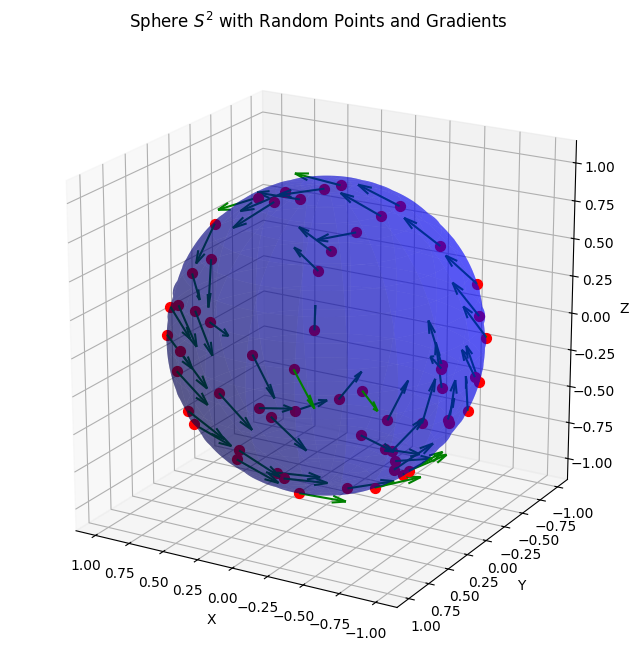

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


class SphereManifold:

  def __init__(self, n=3):
    """
      dim = n - 1
    """
    self.dim = n - 1

  def project_to_tangent_space(self, x, v):
    """
        Project a vector v onto the tangent space at point x on the sphere.
        This is done by subtracting the component of v that is parallel to x.
        """
    return v - np.dot(x, v) * x

  def retraction(self, x, eta):
    """
        Retract a tangent vector eta back to the sphere.
        This is done by moving in the direction of eta and then normalizing.
        """
    y = x + eta
    return y / np.linalg.norm(y)

  def gradient(self, f, x, eps=1e-8):
    """
        Compute the Riemannian gradient of a function f at point x on the sphere.
        The gradient is computed using central finite differences.
        """
    grad = np.zeros_like(x)
    for i in range(len(x)):
      e_i = np.zeros_like(x)
      e_i[i] = 1
      grad[i] = (f(x + eps * e_i) - f(x - eps * e_i)) / (2 * eps)
    return self.project_to_tangent_space(x, grad)

  def random_point(self):
    """
        Generate a random point on the sphere.
        """
    vec = np.random.randn(self.dim + 1)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

  def random_dist(self):
    theta = np.random.uniform(0, 2 * np.pi)
    phi = np.random.uniform(0, np.pi)
    x = np.array([
        np.sin(phi) * np.cos(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(phi)
    ])
    return x


sphere = SphereManifold()

x = sphere.random_point()
y = sphere.random_point()

A2 = np.array([[1, 0], [0, -1]])
A3 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, -1]])


def quotient(x):
  return x.T @ A3 @ x


def quadratic_function(x):
  return np.dot(x, x)


def grad(x):
  return (np.eye(3) - x @ x.T) @ (2 * A3 @ x)


points = [sphere.random_point() for _ in range(60)]
print(points)
grads = [grad(x) for x in points]


def plot_sphere_with_gradients(points, gradients):
  u = np.linspace(0, 2 * np.pi, 100)
  v = np.linspace(0, np.pi, 100)

  x_sphere = np.outer(np.cos(u), np.sin(v))
  y_sphere = np.outer(np.sin(u), np.sin(v))
  z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))

  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(111, projection='3d')

  ax.plot_surface(x_sphere,
                  y_sphere,
                  z_sphere,
                  color='b',
                  alpha=0.4,
                  rstride=5,
                  cstride=5,
                  linewidth=0)

  for point, gradient in zip(points, gradients):
    ax.scatter(point[0], point[1], point[2], color='r', s=50)
    ax.quiver(point[0],
              point[1],
              point[2],
              gradient[0],
              gradient[1],
              gradient[2],
              color='g',
              length=0.1 * np.linalg.norm(gradient, 0),
              normalize=True)

  ax.view_init(elev=20, azim=120)

  ax.set_title("Sphere $S^2$ with Random Points and Gradients")
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.set_box_aspect([1, 1, 1])

  plt.show()


# Generate and plot the points
plot_sphere_with_gradients(points, grads)


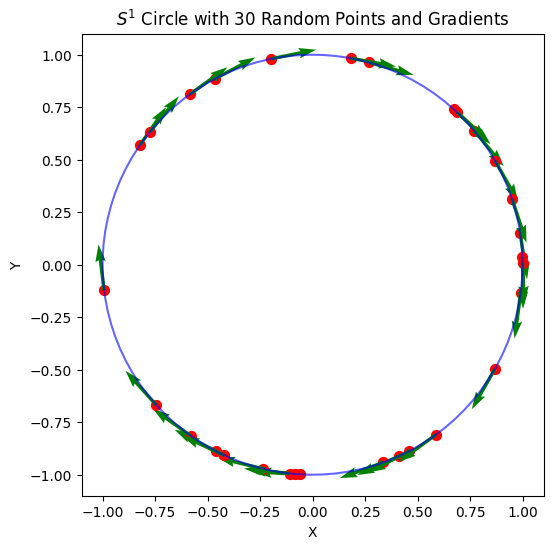

In [108]:
def quotient2(x):
  return x.T @ A2  @ x


def quadratic_function(x):
  return np.dot(x, x)


def grad2(x):
  return (np.eye(2) - x @ x.T) @ (2 * A2 @ x)

circle = SphereManifold(n = 2)

circle_points = [circle.random_point() for _ in range(30)]
circle_gradients = [grad2(x) for x in circle_points]

def plot_circle_with_gradients(points, gradients):
    theta = np.linspace(0, 2 * np.pi, 100)
    x_circle = np.cos(theta)
    y_circle = np.sin(theta)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(x_circle, y_circle, color='b', alpha=0.6)  # Circle

    for point, gradient in zip(points, gradients):
        ax.scatter(point[0], point[1], color='r', s=50)
        ax.quiver(point[0], point[1], gradient[0], gradient[1], color='g', scale=10*np.linalg.norm(gradient,axis=0))


    ax.set_title("$S^1$ Circle with 30 Random Points and Gradients")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal', 'box')

    plt.show()

plot_circle_with_gradients(circle_points, circle_gradients)


## Retraction on the sphere

Let $M = S^{n-1}$ and $N$ the positive Reals. Then the mapping
$$
  \phi : M \times N \to \mathbb{R}_{*}^{n}: (x,r) \mapsto xr.
$$ 
is a Diffeomorphism.

The inverse map $\phi^{-1} : \mathbb{R}^n \to M \times N$ is easy to figure out: Because all Elements of $S^{n-1}$ are unit vectors, $x$ is given by $\frac{v}{\left| v \right|}$ and $r$ is given by $\left|v\right|$.

Then it is easy to see that the Retraction on the N-Sphere is given by $R_x(\xi) = \frac{x + \xi}{\left| x + \xi \right|}$


In [106]:
def retraction(x,xi):
  y = x + xi
  return np.divide(y,np.linalg.norm(y,2))

def g(x,y):
  pass

/tmp/ipykernel_497656/2425432583.py:63: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(path[:, 0], path[:, 1], cmap="winter", marker='o')
/tmp/ipykernel_497656/2425432583.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


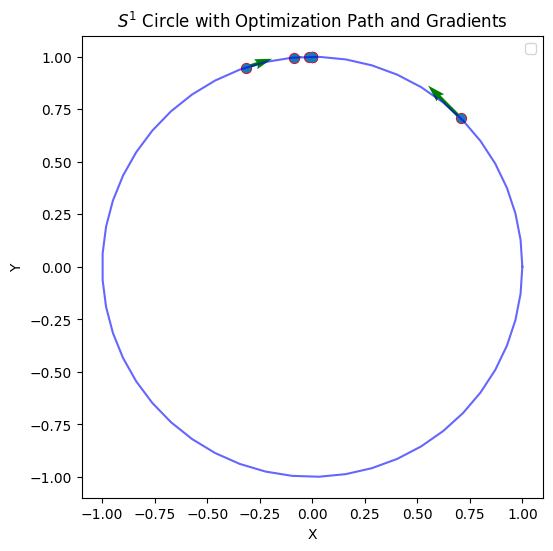

In [133]:
alpha = 1
beta = 0.2
sigma = 0.05


def grad2(x_cur):
  return 2 * (A2 @ x_cur - x_cur * quotient2(x_cur))


def armijo_point(x, f=quotient2, grad=grad2):
  eta = -1.0 * grad(x)
  m = 0
  while True:
    Rx = retraction(x, beta**m * np.conj(alpha) * eta)
    lower = (-1.0 * sigma * grad(x)) @ ((beta**m) * alpha * eta)
    if f(x) - f(Rx) >= lower:
      return alpha * (beta**m)
    m += 1


theta = np.pi / 4  # Azimuthal angle
phi = np.pi / 4  # Polar angle




def search():
  x0 = np.array((np.cos(theta),np.sin(phi)),dtype=float)
  XS = [x0]
  ES = []
  i = 0
  for i in range(1000):
    etak = -grad2(x0)

    ES.append(etak)
    if np.linalg.norm(etak) < 1e-4: break
    tk = armijo_point(x0)
    x0 = retraction(x0, tk * etak)
    XS.append(x0)
  return (np.array(XS), np.array(ES))


path, gradients = search()


def plot_sphere_with_path_and_gradients(points, gradients, path):
  theta = np.linspace(0, 2 * np.pi, 50)
  x_circle = np.cos(theta)
  y_circle = np.sin(theta)

  fig, ax = plt.subplots(figsize=(6, 6))
  ax.plot(x_circle, y_circle, color='b', alpha=0.6)

  for point, gradient in zip(points, gradients):
    ax.scatter(point[0], point[1], color='r', s=50)
    ax.quiver(point[0],
              point[1],
              gradient[0],
              gradient[1],
              color='g',
              scale=10 * np.linalg.norm(gradient, 0))

  ax.scatter(path[:, 0], path[:, 1], cmap="winter", marker='o')

  ax.set_title("$S^1$ Circle with Optimization Path and Gradients")
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_aspect('equal', 'box')

  plt.legend()
  plt.show()


plot_sphere_with_path_and_gradients(path, gradients, path)


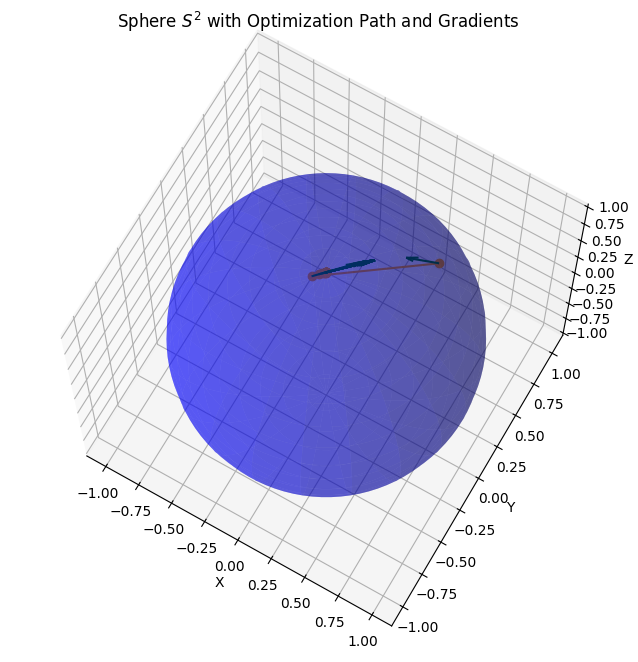

45


In [141]:
alpha = 3
beta = 0.2
sigma = 0.05


def grad3(x_cur):
  return 2 * (A3 @ x_cur - x_cur * quotient(x_cur))


def armijo_point(x, f=quotient, grad=grad3):
  eta = -1.0 * grad(x)
  m = 0
  while True:
    Rx = retraction(x, beta**m * np.conj(alpha) * eta)
    lower = (-1.0 * sigma * grad(x)) @ ((beta**m) * alpha * eta)
    if f(x) - f(Rx) >= lower:
      return alpha * (beta**m)
    m += 1


def search():

  x0 = np.array(
      [np.sin(phi) * np.cos(theta),
       np.sin(phi) * np.sin(theta),
       np.cos(phi)])
  XS = [x0]
  ES = []
  i = 0
  for i in range(1000):
    etak = -grad3(x0)

    ES.append(etak)
    if np.linalg.norm(etak,3) < 1e-4: break
    tk = armijo_point(x0)
    x0 = retraction(x0, tk * etak)
    XS.append(x0)
  return (np.array(XS), np.array(ES))


path, gradients = search()


def plot_sphere_with_path_and_gradients(points, gradients, path):
  u = np.linspace(0, 2 * np.pi, 100)
  v = np.linspace(0, np.pi, 100)

  x_sphere = np.outer(np.cos(u), np.sin(v))
  y_sphere = np.outer(np.sin(u), np.sin(v))
  z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))

  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(111, projection='3d')

  ax.plot_surface(x_sphere,
                  y_sphere,
                  z_sphere,
                  color='b',
                  alpha=0.4,
                  rstride=5,
                  cstride=5,
                  linewidth=0)

  ax.plot(path[:, 0],
          path[:, 1],
          path[:, 2],
          color='orange',
          marker='o',
          label='Optimization Path')

  for point, gradient in zip(path, gradients):
    ax.quiver(point[0],
              point[1],
              point[2],
              gradient[0],
              gradient[1],
              gradient[2],
              color='g',
              length=0.3,
              normalize=True)

  ax.view_init(elev=70, azim=300)

  ax.set_title("Sphere $S^2$ with Optimization Path and Gradients")
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.set_box_aspect([1, 1, 1])

  plt.show()


plot_sphere_with_path_and_gradients(path, gradients, path)
print(path.size)

## Stiefel Manifold

$$ St(n,p) = \{ X \in \mathbb{R}^{n \times p} \mid X^T X = I_p \} $$

In [20]:
from scipy.linalg import qr

def g(x,y):
  return np.trace(x.T @ y)

def qf(X):
  Q,_ = qr(X)
  return Q

def random_point(n,p):
  A = np.random.randn(n,p)
  Q,_ = qr(A)
  return Q

A = random_point(2,2)

def check_is_stiefel(X):
  size = X.shape[0]
  A = X.T @ X
  return np.allclose(A,np.eye(size),10e-3)

def project_to_tangent_space(X,Z):
  I = np.eye(X.shape[0])
  M = X.T @ Z
  skew = 1/2 * (M - M.T)
  proj = (I - X@X.T)@Z - X@skew
  return proj

def st_retraction_1(x,xi):
  return qf(x + xi)

def st_retraction_2(x,xi):
  return (x + xi) @ (np.eye(x.shape[0]) + xi.T @ xi)**(-0.5)



B = np.eye(2)

C = project_to_tangent_space(A,B.T)

C

array([[ 1.11022302e-16, -1.42102144e-17],
       [-1.42102144e-17,  0.00000000e+00]])